# 1. 메모리 변수 제거

In [ ]:
# 메모리 변수 모두 제거
all = [var for var in globals() if var[0] != '_']
for var in all:
    del globals()[var]

# 2. 사용 패키지

## !pip install --upgrade google-cloud-vision  실행후 런타임 다시시작해야함

In [ ]:
!pip install --upgrade google-cloud-vision 

     |████████████████████████████████| 370 kB 4.0 MB/s 
     |████████████████████████████████| 45 kB 3.1 MB/s 
     |████████████████████████████████| 95 kB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 40.1 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 1.26.3
    Uninstalling google-api-core-1.26.3:
      Successfully uninstalled google-api-core-1.26.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-translate 1.5.0 requires google-api-core[grpc]<2.0.0dev,>=1.6.0, but you have google-api-core 2.2.2 which is incompatible.
google-cloud-language 1.2.0 requires google-api-core[grpc]<2.0.0dev,>=1.6.0, but you have google-api-core 2.

In [ ]:
import re
import io
import os
import cv2
import json
import base64
import pickle
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image as Image
from PIL import Image, ImageDraw, ImageFont
from google.colab import files
from google.colab import drive
from google.cloud import vision
from bs4 import BeautifulSoup
import time
from urllib.request import urlopen
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1) # 생략되는 부분 없이 내용 전부 출력

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3. 데이터 로드

## 1) 경로

In [ ]:
path = '/content/drive/MyDrive/Data/데이터셋'

## 2) 음식 이미지 분류 모델

In [ ]:
# 모델 로드
from keras.models import load_model
model = load_model(path + '/kfood/H5/통합_CNN_SAMPLE2.h5')

## 3) 레시피, 재료 데이터

In [ ]:
# 레시피, 재료 데이터 불러오기
df = pd.read_csv(path + '/recipe_en.csv')
df = df.iloc[:, :21]

## 4) 리뷰 데이터

In [ ]:
# review 데이터 불러오기
with open(path + '/review_result.pickle', 'rb') as fr:
    review = pickle.load(fr)
# review['후라이드치킨'] = review.pop('후라이드 치킨')
# review['자장면'] = review.pop('짜장면')

## 5) 알레르기 데이터

In [ ]:
# 알레르기 데이터 불러오기
allergy = pd.read_csv(path + '/allergy_Ingredient.csv')
# 읽어올 때 리스트 데이터를 문자열 형태로 읽어온다.
for a in allergy:
    allergy[a] = [eval(allergy[a][0])]

## 6) 메뉴 파인더

In [ ]:
# 메뉴판에서 메뉴 찾기에 쓰이는 메뉴 파인더
menu_finder = pd.read_csv(path + '/menu_finder.csv')

## 7) 키 데이터

In [ ]:
jsonfile = "/content/drive/MyDrive/Data/소스코드/08.GoogleVisionAPI/data/API_KEY.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = jsonfile

# 4. 출력 함수 정의


## 1) 레시피 출력 함수

In [ ]:
# 레시피 출력
def get_recipe(food_name):
    recipes = pd.DataFrame(df[df.Small_cat == food_name].iloc[:, 7:21])
    recipes = recipes.transpose()
    recipes = recipes.dropna(axis = 0)
    recipes.columns = [food_name]
    return recipes

## 2) 알레르기 출력 함수

In [ ]:
# 알레르기 출력
def get_allergy(food_name):
    for al in allergy.columns:
        for a in allergy[al][0]:
            for ing in  df[df.Small_cat == food_name].Ingredient.iloc[0].split(', '):
                if a in ing:
                    if al == 'Beef':
                        print('Hindu taboo food : ' + ing + '\ntaboo information : ' + al + '\n')
                    elif al == 'Pork':
                        print('Islam taboo food : ' + ing + '\ntaboo information : ' + al + '\n')
                    else:
                        print('Allergy caution : '+ ing +'\nAllergy information : ' + al + '\n')

## 3) 리뷰 점수 출력 함수

In [ ]:
# review 점수 결과 반환
def get_review_score(food_name):
    return round(((review[food_name].count('positive') / len(review[food_name])) * 100), 2)

## 4) 음식이름 가지고오기(영어이름 1, 2)

In [ ]:
def get_eng_food_name(food_name):
    eng_name1 = df[df.Small_cat == food_name]['Small_cat_en1'].iloc[0]
    eng_name2 = df[df.Small_cat == food_name]['Small_cat_en2'].iloc[0]
    return eng_name1, eng_name2

## 5) 대표이미지 가지고오기

In [ ]:
def get_representative_image(food_name):
  img_path = '/content/drive/MyDrive/Data/데이터셋/음식대표이미지/' + food_name + '.jpg'
  img = Image.open(img_path)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

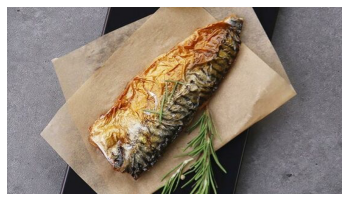

In [ ]:
get_representative_image('고등어구이')

## 6) 메뉴판 CLOVA

In [ ]:
# 메뉴판 clova
def get_menu_img_txt(img_path):
    f = open(img_path, 'rb')
    img = base64.b64encode(f.read())
    # 본인의 APIGW Invoke URL로 치환
    URL = "https://753be9f191e84997b6a1cb14d20ae459.apigw.ntruss.com/custom/v1/11837/f75a234e7e7b1d793b15cc0e685df3ff05ba5a55c3702d20de053111d4882541/general"
    # 본인의 Secret Key로 치환
    KEY = "aVVRWGxBZUJkbUhqUXBpd05OaktuUlpPdFVuaU5QQ0M="
    headers = {
        "Content-Type": "application/json",
        "X-OCR-SECRET": KEY
    }
    data = {
        "version": "V1",
        "requestId": "sample_id", # 요청을 구분하기 위한 ID, 사용자가 정의
        "timestamp": 0, # 현재 시간값
        "images": [
                   {"name": "sample_image",
                    "format": "png",
                    "data": img.decode('utf-8')
                    # "templateIds": [400]  # 설정하지 않을 경우, 자동으로 템플릿을 찾음
                    }
                   ]
    }
    data = json.dumps(data)
    response = requests.post(URL, data=data, headers=headers)
    res = json.loads(response.text)
    
    menu_all = res['images'][0]['fields']
    # res['images'][0]['fields']
    # 클로바 ocr에서 찾은 텍스트 중에서 메뉴들만 추출한다.
    found_menu = []
    for i in range(len(menu_finder)):
        for menu in menu_all:
            temp = {}
            for fn in menu_finder['find_name'][i].split(','):
                if fn in menu['inferText']:
                    temp['menu_name'] = menu_finder['menu_name'][i]
                    temp['inferText'] = menu['inferText']
                    temp['data_h'] = menu_finder['data_h'][i]
                    # 좌표가지고 오기
                    temp['xy'] = [menu['boundingPoly']['vertices'][0]['x'], menu['boundingPoly']['vertices'][0]['y'], menu['boundingPoly']['vertices'][2]['x'], menu['boundingPoly']['vertices'][2]['y']]
                    # del(temp['find_name'])
                    found_menu.append(temp)
    return found_menu

## 7) 음성 & 텍스트 CLOVA


In [ ]:
client_id = 'mu5p1uj3j2'
client_secret = 'rmz4IYQbITxiFn8bjUQ9V9ehr7oDkTo5tOUOJfs3'

lang = "Eng"    # 언어 코드 ( Kor, Jpn, Eng, Chn )
def get_stt():
  file = list(files.upload().keys())[0]
  url = "https://naveropenapi.apigw.ntruss.com/recog/v1/stt?lang=" + lang
  data = open(file, 'rb')
  headers = {
      "X-NCP-APIGW-API-KEY-ID": client_id,
      "X-NCP-APIGW-API-KEY": client_secret,
      "Content-Type": "application/octet-stream"
  }

  response = requests.post(url,  data=data, headers=headers)

  rescode = response.status_code

  #if(rescode == 200):
  #    print(response.text)
  #else:
  #    print("Error : " + response.text)

  return eval(response.text)['text']

## 8) 음식 이미지 BOUNDING BOX, CROP, PREDICT

In [ ]:
def crop_img(file_name):
  client = vision.ImageAnnotatorClient()
  with open(file_name, 'rb') as image_file:
      content = image_file.read()
  image = vision.Image(content = content)
  objects = client.object_localization(image = image).localized_object_annotations
  #print('Number of objects found : {}'.format(len(objects)))
  df = pd.DataFrame(columns = ['name', 'confidence', 'x', 'y'])
  for object_ in objects:
     #print('\n{} (confidence : {})'.format(object_.name, object_.score))
     # print('Normalized bounding polygon vertices : ')
      x, y = [], []
      for vertex in object_.bounding_poly.normalized_vertices:
          #print(' - ({}, {})'.format(vertex.x, vertex.y))
          x.append(vertex.x)
          y.append(vertex.y)
      new_data = {'name' : object_.name, 'confidence' : object_.score, 'x' : x, 'y' : y}
      df = df.append(new_data, ignore_index = True)

  df = df[(df.name == 'Food') | (df.name == 'Bowl')]
  df = df.reset_index().drop(columns ='index')
  return df

def draw_rect(image, point1, point2, label): #사진에 그림그려준다
    font = ImageFont.truetype("LiberationMono-Bold.ttf", 20) #폰트설정 폰트크기설정
    draw = ImageDraw.Draw(image)
    draw.rectangle((point1, point2), outline = (0, 255, 0), width = 2)
    draw.text(point1, label, fill = 'red', font= font)
    return image

def predict_img(img):
  img = img.convert('RGB')
  img = img.resize((64, 64))
  imgarr = np.array(img) / 255
  imgarr = np.array([imgarr,], dtype = 'float32')
  #print(imgarr.shape)
  #print(type(imgarr))
  pred = model.predict(imgarr)
  #print('----- X -----')
  #plt.imshow(imgarr)
  #plt.show()
  class_names = ['갈비구이', '갈비찜', '갈치조림', '계란말이', '고등어구이',
                '김밥', '김치찌개', '닭갈비', '닭볶음탕', '떡볶이',
                '라면', '만두', '미역국', '배추김치', '보쌈',
                '불고기', '비빔밥', '삼겹살', '삼계탕', '양념치킨',
                '육개장', '잡채', '제육볶음', '족발', '짜장면',
                '짬뽕', '파전', '후라이드치킨']
#  print('----- PREDICT -----')
#  for i in pred:
#      print(np.argmax(i), class_names[np.argmax(i)])
  food_name = class_names[np.argmax(pred)]
  return food_name

## 9) 재료 크롤링

In [ ]:
def get_food_product(food_name):
  ingredient = df[df.Small_cat == food_name].Ingredient.iloc[0]

  ingredient = ingredient.split(',')[:3]
  all_url = []
  all_product = []
  img_list = []
  for ing in ingredient:
    url = f"https://www.ebay.com/sch/i.html?_from=R40&_nkw={ing}&_sacat=14308&LH_TitleDesc=0&rt=nc&LH_BO=1"
    url = url.replace(" ", "%20")
    html = urlopen(url)
    soup = BeautifulSoup(html,'html.parser')
    list = soup.select(".s-item")
    for i in range(1,2):
      img = list[i].select_one(".s-item__image-img")['src']
      urls = list[i].select_one(".s-item__link")['href']
      products = list[i].select_one('.s-item__title').text
      all_url.append(urls)
      all_product.append(products)
      with urlopen(img) as f:
          with open('/content/' + ing + str(i)+'.jpg','wb') as h: # 이미지 + 사진번호 + 확장자는 jpg
              img = f.read() #이미지 읽기
              h.write(img) # 이미지 저장
              img_list.append('/content/' + ing + str(i)+'.jpg')
  return ingredient, all_url, all_product, img_list

def show_food_product(ing, url, product, img):
  for i in range(len(img)):
    print('ingredient name=' +ing[i],'\nproduct_name=' +product[i], '\nproduct_url='+url[i])
    img_show = Image.open(img[i])
    plt.imshow(img_show)
    plt.axis('off')
    plt.show()

# 5. 음식 이미지

In [ ]:
filename = list(files.upload().keys())[0]
crop_df = crop_img(filename) #bowl과 food df로 받아온다

w, h = image.size
label_pre =[]
for i in range(len(crop_df)):
    x = crop_df.x[i]
    y = crop_df.y[i]
    crop_img = image.crop((w * min(x), h * min(y), w * max(x), h * max(y)))
    img = crop_img
    pre = predict_img(img)
    label_pre.append(pre)

crop_df['label'] = label_pre

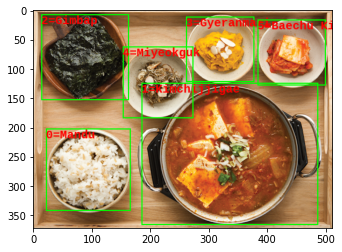

In [ ]:
image = Image.open(filename)
for i in range(len(crop_df)):
    eng = df[df.Small_cat == crop_df['label'][i]]['Small_cat_en1'].iloc[0] # 영어명으로 넣었다(한글사용시 한글폰트 업데이트 필요)
    label = str(i) + '=' + eng
    x = crop_df.x[i]
    y = crop_df.y[i]
    image = draw_rect(image, (w * min(x), h * min(y)), (w * max(x), h * max(y)), label)
plt.imshow(np.array(image))
plt.axis('off')
plt.show()

In [ ]:
sentence =''
for i, l in enumerate(crop_df.label):
  sentence = f' {i}:'.join([sentence,df[df.Small_cat == l]['Small_cat_en1'].iloc[0]])

food_num = int(input(sentence+' ==>select num:'))

food_name = crop_df.label[food_num]
print(get_eng_food_name(food_name))
print(get_recipe(food_name))
get_allergy(food_name)
print('The Ratio of Positive review:', get_review_score(food_name))
print('\nfood ingredient:',df[df.Small_cat == food_name].Ingredient.iloc[0])


x, y, z, q = get_food_product(food_name)
show_food_product(x, y, z, q)

show_food_product(get_representative_image(food_name))


이미지 파일을 업로드 해주세요.


Saving Img_000_0000.jpg to Img_000_0000.jpg
(1, 64, 64, 3)
<class 'numpy.ndarray'>
----- X -----


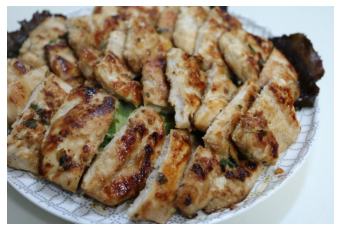

----- PREDICT -----
17 삼겹살


In [ ]:
## 음식 하나일때
print('이미지 파일을 업로드 해주세요.')
filename = list(files.upload().keys())[0]
img2 = Image.open(filename)
img = Image.open(filename)
img = img.convert('RGB')
img = img.resize((64, 64))
imgarr = np.array(img) / 255
imgarr = np.array([imgarr,], dtype = 'float32')
print(imgarr.shape)
print(type(imgarr))
pred = model.predict(imgarr)
print('----- X -----')
#plt.imshow(imgarr)
plt.axis('off')
plt.imshow(img2)
plt.show()
class_names = ['갈비구이', '갈비찜', '갈치조림', '계란말이', '고등어구이',
               '김밥', '김치찌개', '닭갈비', '닭볶음탕', '떡볶이',
               '라면', '만두', '미역국', '배추김치', '보쌈',
               '불고기', '비빔밥', '삼겹살', '삼계탕', '양념치킨',
               '육개장', '잡채', '제육볶음', '족발', '짜장면',
               '짬뽕', '파전', '후라이드치킨']
print('----- PREDICT -----')
for i in pred:
    print(np.argmax(i), class_names[np.argmax(i)])
food_name = class_names[np.argmax(i)]

('Pajeon', 'Green Onion Pancake')


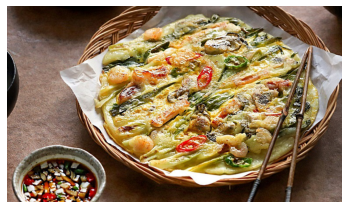

Allergy caution : flour
Allergy information : Wheat 

The Ratio of Positive review: 70.0

food ingredient: soybean paste, flour, green onion, sugar, vegetable oil, water
                                                                                                                                                                                                        파전
Step1   Clean, wash, and drain a handful of wild green onions (or about 10 stalks of normal green onion). Cut them into 5 inch long pieces.                                                               
Step2   Make batter by mixing ½ cup flour, ½ cup water, 1 ts soybean paste, and ½ ts sugar in a bowl. Mix well until the batter is smooth.                                                                
Step3   Place a non-stick pan on the stove and heat it up.                                                                                                                                                
Step4   Add about 

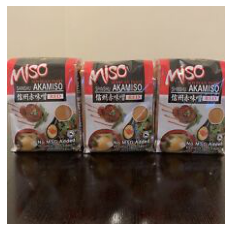

ingredient name= flour 
product_name=Member's Mark All Purpose Flour (25 lbs.) 
product_url=https://www.ebay.com/itm/264960151713?hash=item3db0db10a1%3Ag%3AYAIAAOSwj9Bfxopy&LH_BO=1


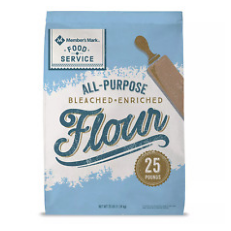

ingredient name= green onion 
product_name=Laura Scudder's Best Onion Dip Ever! Green Onion Dip Mix Seasoning Powder. 
product_url=https://www.ebay.com/itm/384418740362?_trkparms=ispr%3D1&hash=item598124788a%3Ag%3AUysAAOSwBU1hVBzj&amdata=enc%3AAQAGAAACkPYe5NmHp%252B2JMhMi7yxGiTJkPrKr5t53CooMSQt2orsSQuF9OYLb3wphIAOfpJK8Rk8S2qpYlu6Qrgw4KTxCxCJzdRqwQ5uUPvHQhELUkxgdVCog67R8hKKghecpKi77MgBLPkuabVgvO%252BFQ8uwmV4lQgy%252Fn0Z3kq4LGLQ5gpARbovSLEghi9e%252F9eDFha51uQzxJ37ZxfxOqOtagD0HwabK2l0vmAY5TGOVFDXrWQhfH%252BowNC1uAaTMRvoDWcrT9bdge0M%252FCU%252FGdSw5b8%252FTakRbBk03fDM43XwhByRqbmMhzdimkA3DR8R5UHN0Y6t7FX%252FSvkNAOCAiGqYcnSjDVpXQeC63%252BaofXyMbfhMzJ29PYSJta7d8ByZPK0aSGNhpw1SW8pkvLOdeX1Igv4s6gf4OBw3GkQfOg9Rea1BBrCTT%252B%252BrVnPenYgyHjgBfaA4B91lUPxXzRfKvuu3q6Fw0ZnGJqM1CLhP8gT0UXO8y7LcnX5XYtVEZsQ7OjruGS%252BRmXuwyqa3yAMtQ9QQIAWpcEGLKKuC0vuNnIAU2dQ722RrYGuG%252BKz2%252Bz7McvW7FSbgnAQPgyJSf2gBKHE%252FtkfKFbqhsWyy1B83cQH7AVJWFLhzPzaKXfBx6f2m9njgcKRbYrYT4KuFYpJtsKImzcOzTCvyi9ptQm5WEb0MvpJldJJvIj

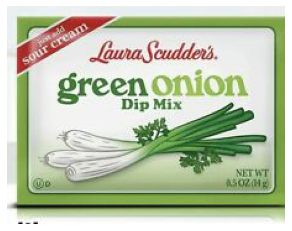

In [ ]:
print(get_eng_food_name(food_name))
get_representative_image(food_name)
get_allergy(food_name)
print('The Ratio of Positive review:', get_review_score(food_name))
print('\nfood ingredient:',df[df.Small_cat == food_name].Ingredient.iloc[0])
print(get_recipe(food_name))
x, y, z, q = get_food_product(food_name)
show_food_product(x, y, z, q)



# 6. 메뉴판 이미지 입력

Saving 33.jpg to 33.jpg
0 = 매운닭갈비 : 닭갈비 : ('Dakgalbi', 'Spicy Stir-fried Chicken')
1 = 비빔밥 : 비빔밥 : ('Bibimbap', 'Bibimbap')
2 = 파전 : 파전 : ('Pajeon', 'Green Onion Pancake')
3 = 삼계탕 : 삼계탕 : ('Samgyetang', 'Ginseng Chicken Soup')
4 = 궁중삼계탕- : 삼계탕 : ('Samgyetang', 'Ginseng Chicken Soup')
5 = 한방삼계탕 : 삼계탕 : ('Samgyetang', 'Ginseng Chicken Soup')
6 = 전복삼계탕 : 삼계탕 : ('Samgyetang', 'Ginseng Chicken Soup')
7 = 갈비탕 : 갈비탕
8 = 동태찌개 : 동태찌개
9 = 도토리묵 : 도토리묵
10 = 소주 : 소주
11 = 맥주 : 맥주
12 = 매운막국수 : 막국수


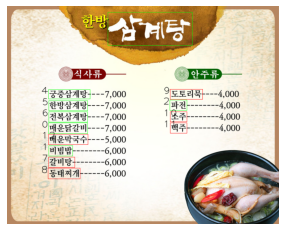

In [ ]:
import shutil
#img_path = path + '/menu/갈비.jpg'
filename = list(files.upload().keys())[0]
shutil.move(filename, path + '/menu/' + filename)
img_path = path + '/menu/' + filename
found_menu = get_menu_img_txt(img_path)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# OpenCV는 기본적으로 BGR 형식을 따르므로, RGB 형식으로 변경
image_width, image_height = Image.open(img_path).size[0], Image.open(img_path).size[1]
for i, menu in enumerate(found_menu):
    xy = menu['xy']
    # 왼쪽 위 좌표와 오른쪽 아래 좌표
    x1, y1 = xy[0], xy[1]
    x2, y2 = xy[2], xy[3]
    if menu['data_h'] == 1:
        c = (0, 255, 0) # mask인 경우 초록색
    else:
        c = (255, 0, 0)
    # 사각형 그리기
    cv2.rectangle(
        img,
        (int(x1), int(y1)), # 왼쪽 위 좌표
        (int(x2), int(y2)), # 오른쪽 아래 좌표
        color = c, # 색상
      thickness = 1, # 굵기
    )
    cv2.putText(img, str(i) , (int(x1-20), int((y1+y2)/2)), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,0),1, cv2.LINE_AA)
    # cv2.putText(img, "It's Winter", (350, 40), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0), 1, cv2.LINE_AA)

    if menu['data_h'] == 1:
      print(f"{i} = {menu['inferText']} : {menu['menu_name']} : {get_eng_food_name(menu['menu_name'])}")
    else:
      print(f"{i} = {menu['inferText']} : {menu['menu_name']}")
    # 텍스트 그리기
plt.imshow(img)
plt.axis('off')
plt.show()

메뉴번호선택2
('Pajeon', 'Green Onion Pancake')


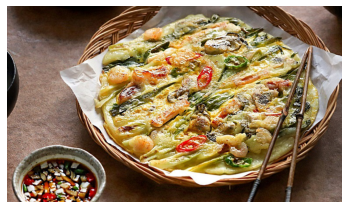

Allergy caution : flour
Allergy information : Wheat 

The Ratio of Positive review: 70.0

food ingredient: soybean paste, flour, green onion, sugar, vegetable oil, water
                                                                                                                                                                                                        파전
Step1   Clean, wash, and drain a handful of wild green onions (or about 10 stalks of normal green onion). Cut them into 5 inch long pieces.                                                               
Step2   Make batter by mixing ½ cup flour, ½ cup water, 1 ts soybean paste, and ½ ts sugar in a bowl. Mix well until the batter is smooth.                                                                
Step3   Place a non-stick pan on the stove and heat it up.                                                                                                                                                
Step4   Add about 

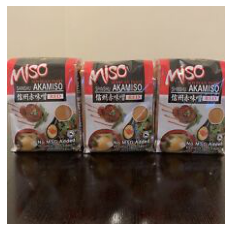

ingredient name= flour 
product_name=Member's Mark All Purpose Flour (25 lbs.) 
product_url=https://www.ebay.com/itm/264960151713?hash=item3db0db10a1%3Ag%3AYAIAAOSwj9Bfxopy&LH_BO=1


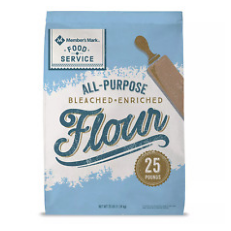

ingredient name= green onion 
product_name=Laura Scudder's Best Onion Dip Ever! Green Onion Dip Mix Seasoning Powder. 
product_url=https://www.ebay.com/itm/384418740362?_trkparms=ispr%3D1&hash=item598124788a%3Ag%3AUysAAOSwBU1hVBzj&amdata=enc%3AAQAGAAACkPYe5NmHp%252B2JMhMi7yxGiTJkPrKr5t53CooMSQt2orsSQuF9OYLb3wphIAOfpJK8Rk8S2qpYlu6Qrgw4KTxCxCJzdRqwQ5uUPvHQhELUkxgdVCog67R8hKKghecpKi77MgBLPkuabVgvO%252BFQ8uwmV4lQgy%252Fn0Z3kq4LGLQ5gpARbovSLEghi9e%252F9eDFha51uQzxJ37ZxfxOqOtagD0HwabK2l0vmAY5TGOVFDXrWQhfH%252BowNC1uAaTMRvoDWcrT9bdge0M%252FCU%252FGdSw5b8%252FTakRbBk03fDM43XwhByRqbmMhzdimkA3DR8R5UHN0Y6t7FX%252FSvkNAOCAiGqYcnSjDVpXQeC63%252BaofXyMbfhMzJ29PYTrb6QTFUy3Iqao2jOGyZu%252BqNIYIK%252F%252BJUplRgDfIpMYL9azs5FxN9G5pstrwts4MwgOx3jIfIbbfL%252F8vJiLZNrDy6CX7OKf8CweaFnDCSYXsRIJAlKp2nag2XxCzOQ1gcvHXWN0pwl1B1QJH60JQ92tP0XKLVpt7pyeGFkyagzDdQZWmHJgYy8p9va0DDr9f%252BcT7XEzusPl0l%252BHyGYAjexNTtU%252BRwZwF5yWRpxzrbacHsaFBhXOHwsvROFjVnbfHrBfFFXiY2HNPVR9Q5aCWEyu%252BAz7o6WA%252FL7H2S9JlpytIAOt3E4IW5

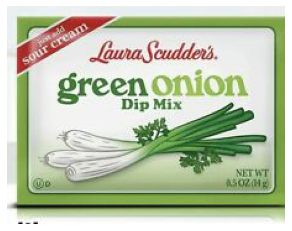

메뉴번호선택-1


In [ ]:
found_menu = [menu for menu in found_menu if menu['data_h']==1]## 찾은메뉴 중 데이터가 있는 메뉴만 

while 1:
  f_num = int(input("메뉴번호선택"))
  if f_num >= len(found_menu):
    print('메뉴를 다시선택해주세요')
  elif f_num == -1:
    break
  else:
    food_name = found_menu[f_num]['menu_name']
    print(get_eng_food_name(food_name))
    get_representative_image(food_name)
    get_allergy(food_name)
    print('The Ratio of Positive review:', get_review_score(food_name))
    print('\nfood ingredient:',df[df.Small_cat == food_name].Ingredient.iloc[0])
    print(get_recipe(food_name))

    x, y, z, q = get_food_product(food_name)
    show_food_product(x, y, z, q)

    

# 7. 음성 데이터 입력
- 음성 데이터 STT 할때 정확도가 많이 떨어짐
- 간단한게 하는 방법은 STT 결과에 food_name이 없다면 다시 음성을 입력하는 방식(ex_ 발음이 부정확하여 다시 음성입력해 주세요)
- 어려운 방식은 음성 분류 모델 만들기(음성을 데이터화 시켜서 딥러닝 분류모델로 만들수 있음)
  - 데이터셋은 clova speach를 통해서 생성가능하다
  - 음식이름만 입력가능하다는 (단점 - how to make ... 못쓴다)

Saving 불고기_how to make 불고기.m4a to 불고기_how to make 불고기 (1).m4a
how to make bulgogi
Bulgogi
('Bulgogi', 'Bulgogi')


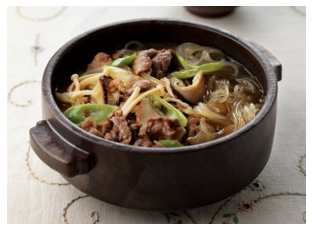

Hindu taboo food : beef tenderloin
taboo information : Beef

Allergy caution : pear
Allergy information : Fruit

The Ratio of Positive review: 86.67

food ingredient: beef tenderloin, pear, onion, garlic, ginger, green onion, soy sauce, brown sugar(rice syrup), ground black pepper, toasted sesame oil, carrot
                                                                                                                                                                                                           불고기
Step1  Mix all the marinade ingredients in a bowl.                                                                                                                                                            
Step2  Add the sliced beef and mix well.                                                                                                                                                                      
Step3  You can grill, pan-fry, or BBQ right after marinating, but it’

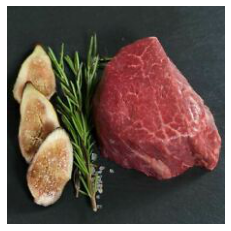

ingredient name= pear 
product_name=Natural Pears Fruit Spreads Premium Quality Free Ship 100% Fresh Pears Spread 
product_url=https://www.ebay.com/itm/164951438736?_trkparms=ispr%3D1&hash=item2667df3590%3Ag%3AIIkAAOSwOi5gwhVo&amdata=enc%3AAQAGAAACkPYe5NmHp%252B2JMhMi7yxGiTJkPrKr5t53CooMSQt2orsSLY2M1Gjmuwt9c03vWNfiRvrfqxOjHRHYoUhQO28JyC3TzWHaQs36VE2XpR%252F6X66yJ03vt8r6OzCsvwbmuhowzywFKpfTTeo0M6IEZxIcBLzDyJZjG6SmEFOBLCTqs3w49zTcCK2qudLIVWzqiKAZVKJr%252BWCCawd9ZYWq0%252Fznqwc6WlYfdhe7drELfBc7G5JUxuH70kdg%252BSCixNbNDTesS0dn8PezFxDGv9YtH7YsAqly3Z9EUuweRw90E3WqzcTQ8PSeWOT12siqZyXxRpMD8l%252BxJUqbcuyCQrBvX5eC2jxS1qo1a04T%252FffNYYg6ItyMpXg3mSmlqfPRRbYhZrHBsjJQuS797s8UpW5kFtXAweFP56RdzBtMW5DaRSeKh5EAFGK66SsP7N7ABdSOQznSdWcQ9Wg6KgX6r%252BGM9g5Ts77vIK2zcQRPbjbpZrDy63HoLg%252BlZXkwdQdU7u3N5jE%252FwJo86mvlCDT9%252FrvdyWLkLjQqi%252BN6px%252FsmDRHECRbr8ySGiQQRs8JJE2wvDWWjA%252Fl0%252FNlKGXoS6kXbb6LMxuSzuVPMzVdzWvkTwkPOQhPiF6JEzkwLAHswlweoerBdvztoFBq4%252BM2p%252F%252F84RDvHeG%252B79lFzdQ%252BxW3c

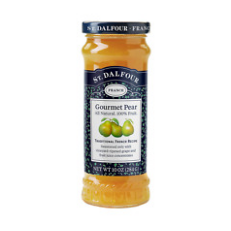

ingredient name= onion 
product_name=Frito-Lay Classic Mix Variety Pack (50 pk.) FREE SHIPPING 
product_url=https://www.ebay.com/itm/184806199846?epid=682165105&hash=item2b074ed226%3Ag%3AhYEAAOSwDH1gjaoV&LH_BO=1


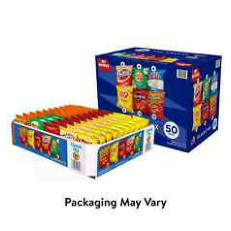

In [ ]:
while 1:
  food = []
  food_sound_result = get_stt()
  print(food_sound_result)
  for i in df['Small_cat_en1']:
    if i.lower() in food_sound_result:
      print(i)
      food.append(i)
  
  if food == []:
    print('발음이 부정확합니다.')
  else:
    food_name = df[df['Small_cat_en1']==food[0]]['Small_cat'].iloc[0]
    print(get_eng_food_name(food_name))
    get_representative_image(food_name)
    get_allergy(food_name)
    print('The Ratio of Positive review:', get_review_score(food_name))
    print('\nfood ingredient:',df[df.Small_cat == food_name].Ingredient.iloc[0])
    print(get_recipe(food_name))
    x, y, z, q = get_food_product(food_name)
    show_food_product(x, y, z, q)
    
    break

# 8. 텍스트 입력

In [ ]:
df[['Small_cat_en1', 'Small_cat_en2']].items

<bound method DataFrame.items of         Small_cat_en1                Small_cat_en2
0   Galbigui           Grilled Galbi              
1   Godeungeogui       Grilled Mackerel           
2   Dakgalbi           Spicy Stir-fried Chicken   
3   Bulgogi            Bulgogi                    
4   Samgyeopsal        Grilled Pork Belly         
5   Miyeokguk          Seaweed Soup               
6   Yukgaejang         Spicy Beef Soup            
7   Yangnyeom Chicken  Seasoned Fried Chicken     
8   Fried Chicken      Fried Chicken              
9   Baechu Kimchi      Napa Cabbage Kimchi        
10  Mandu              Mandu                      
11  Ramyeon            Ramyeon                    
12  Jajangmyeon        Noodles in Black Bean Sauce
13  Jjamppong          Spicy Seafood Noodle Soup  
14  Japchae            Japchae                    
15  Gimbap             Gimbap                     
16  Bibimbap           Bibimbap                   
17  Tteokbokki         Tteokbokki                

input food name:Bulgogi
('Bulgogi', 'Bulgogi')


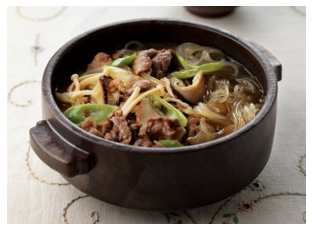

Hindu taboo food : beef tenderloin
taboo information : Beef

Allergy caution : pear
Allergy information : Fruit

The Ratio of Positive review: 86.67

food ingredient: beef tenderloin, pear, onion, garlic, ginger, green onion, soy sauce, brown sugar(rice syrup), ground black pepper, toasted sesame oil, carrot
                                                                                                                                                                                                           불고기
Step1  Mix all the marinade ingredients in a bowl.                                                                                                                                                            
Step2  Add the sliced beef and mix well.                                                                                                                                                                      
Step3  You can grill, pan-fry, or BBQ right after marinating, but it’

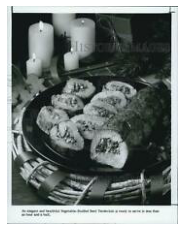

ingredient name= pear 
product_name=Vodka Absolut Pera Pear Cl 70 Secca 
product_url=https://www.ebay.com/itm/304018898264?hash=item46c8f03d58%3Ag%3AsFwAAOSwGYZfzkyl&LH_BO=1


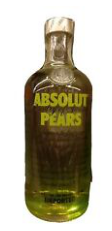

ingredient name= onion 
product_name=Spring Onion Semolina 40 G Salad Crudité Meats Fish Sauces Mudflaps Mitre 
product_url=https://www.ebay.com/itm/264779827322?hash=item3da61b887a%3Ag%3AC1IAAOSwEcxgbD5o&LH_BO=1


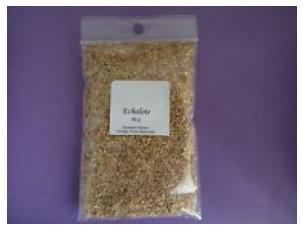

input food name:1


In [ ]:
while 1: ## 영어이름으로 찾기
  food_name_eng = input('input food name:') # 1입력시 끝

  if df['Small_cat_en1'].isin([food_name_eng]).sum():
    food_name =  df.Small_cat[df['Small_cat_en1'].isin([food_name_eng])].iloc[0]
    print(get_eng_food_name(food_name))
    get_representative_image(food_name)
    get_allergy(food_name)
    print('The Ratio of Positive review:', get_review_score(food_name))
    print('\nfood ingredient:',df[df.Small_cat == food_name].Ingredient.iloc[0])
    print(get_recipe(food_name))

    x, y, z, q = get_food_product(food_name)
    show_food_product(x, y, z, q)
    
  elif df['Small_cat_en2'].isin([food_name_eng]).sum():
    food_name =  df.Small_cat[df['Small_cat_en2'].isin([food_name_eng])].iloc[0]
    print(get_eng_food_name(food_name))
    get_representative_image(food_name)
    get_allergy(food_name)
    print('The Ratio of Positive review:', get_review_score(food_name))
    print('\nfood ingredient:',df[df.Small_cat == food_name].Ingredient.iloc[0])
    print(get_recipe(food_name))

    x, y, z, q = get_food_product(food_name)
    show_food_product(x, y, z, q)
    

  elif food_name_eng == '1':
    break
  else:
    print('wrong food name')

## 출력

In [ ]:
while 1:
  select_menu = int(input('음식사진 --> 1 \n메뉴사진 --> 2 \n음성입력 --> 3 \n텍스트 입력 --> 4 \n'))
  if select_menu == 1:
    print('음식사진')
  
  elif select_menu == 2:
    print('메뉴사진')
   
  elif select_menu == 3 :
    print('음성')

  elif select_menu == 4:
    print('텍스트')

  else:
    break